# ITCS 6156 Machine Learning Final Project 
## Segmentation 

The objective of this program is to take the MRI images as input and remove the brain from the skull using segmentation. The output image should contain only the extracted brain without the skull. 

In [32]:
# First we import the necessary libraries.
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
#from skimage.morphology import watershed as skwater
# To resolve error with importing watershed, 
!pip install aicssegmentation==0.5.0

In order to understand the current state of the MRI images, we can create a funtion to print these images showing both the brain and the skull. An example of this is included below.

In [33]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(10, 10))
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get bgr
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

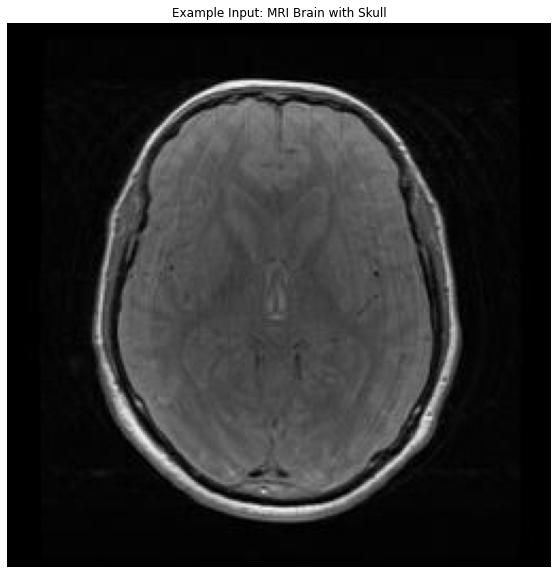

In [34]:
img = cv2.imread('sample_mri.jpeg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ShowImage('Example Input: MRI Brain with Skull', gray_img, 'gray')

### Extract a Mask

We can use plt.hist() to create a histogram of the image. By doing so, we can check if the histogram is bimodal which indicates that the pixels in the image can be classified into two different intensity classes. A bimodel histogram allows for the application of Ostu's method to threshold the pixels, creating a binary mask. An example of this process can be seen below using the same image from the previous example.

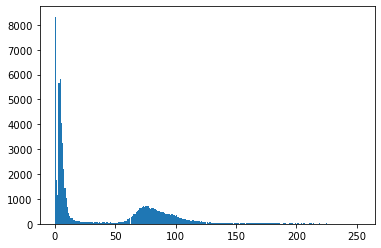

In [35]:
# Create a histogram of the intensities in the grayscale image
plt.hist(gray_img.ravel(),256)
plt.show()

We can see in the plot above that the image does have a bimodal hisogram. Now we can threshold the pixels to create the binary mask.

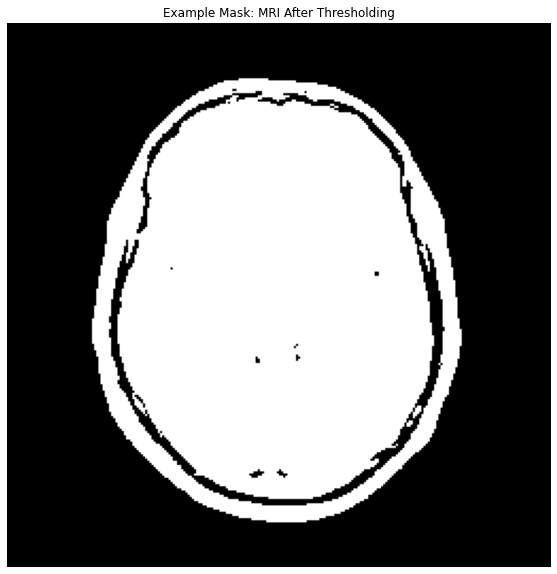

In [117]:
# Threshold the pixels to create binary mask using Otsu's method
ret, thresh = cv2.threshold(gray_img, 140, 255, cv2.THRESH_OTSU)
ShowImage('Example Mask: MRI After Thresholding', thresh, 'gray')

The thresholding method cannot differentiate between the skull and the brain. There are a few pixels connecting the two shapes so the two parts will read as a single object. We can try another method...

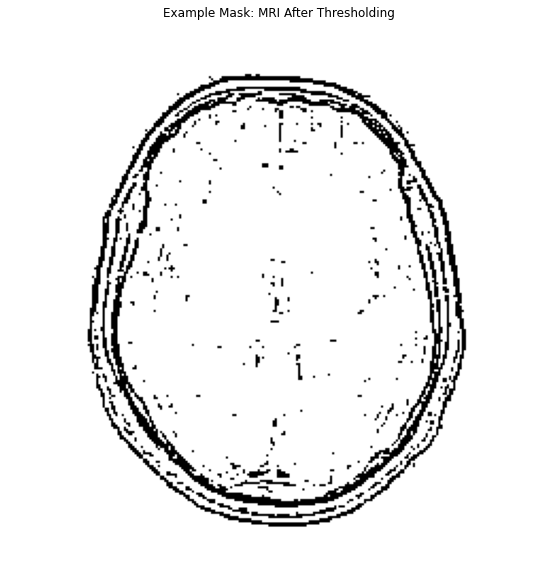

In [147]:
thresh = cv2.adaptiveThreshold(gray_img, 255, cv2.THRESH_BINARY, cv2.ADAPTIVE_THRESH_MEAN_C, 5, 9)
ShowImage('Example Mask: MRI After Thresholding', thresh, 'gray')

We can see the same issue here. There are pixels connecting the two shapes, so this will read as a single object.

##### It may be easier to see the results of the thresholding by overlaying the mask on the original image. This is done below.

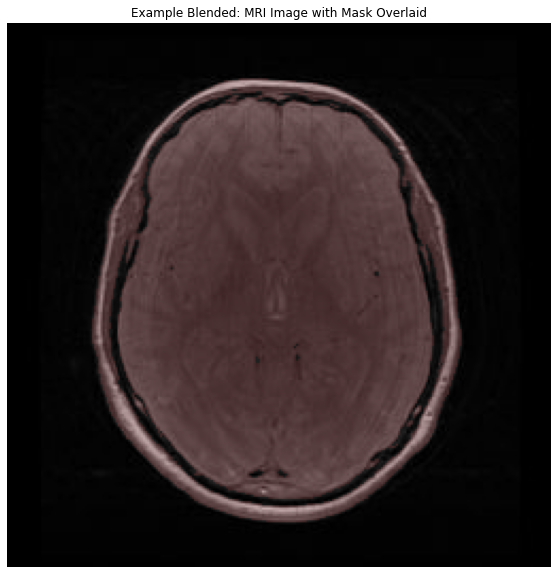

In [119]:
colormask = np.zeros(img.shape, dtype=np.uint8)
colormask[thresh != 0] = np.array((0,0,255))
blended = cv2.addWeighted(img, 0.7, colormask, 0.1,0)
ShowImage('Example Blended: MRI Image with Mask Overlaid', blended, 'bgr')

### Extract the Brain

In order to remove the brain from the rest of the MRI, we must extract the connected components from the mask and find the component with the largest area, which is expected to be the brain. The mistake in the mask generation will be seen clearly here as the skull and brain are both still in the image.

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


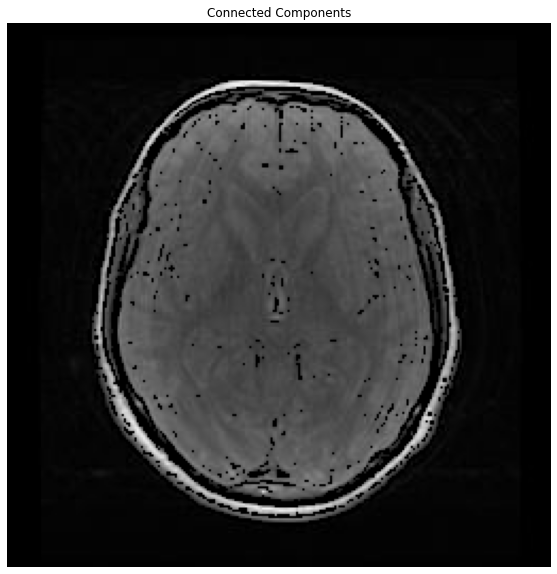

In [148]:
# img2 = cv2.bitwise_not(thresh)     
# _, markers2 = cv2.connectedComponents(img2)

ret, markers = cv2.connectedComponents(thresh)
print(markers)

# Get the area of each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers == m) for m in range(np.max(markers)) if m != 0] 
# Get label of largest component by area
largest_component = np.argmax(marker_area) + 1 #Add 1 since we dropped zero above                        
# Get pixels which correspond to the brain
brain_mask = markers == largest_component

#In a copy of the original image, clear the pixels that don't correspond to the brain
brain_out = img.copy()
brain_out[brain_mask==False] = (0,0,0)
ShowImage('Connected Components', brain_out, 'rgb')